In [1]:
DATA_DIR = 'datasets/'
DATASET = 'AAPL'

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [3]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import keras.backend as K

Using TensorFlow backend.


In [4]:
init_notebook_mode(connected=True)

In [5]:
!ls datasets

AAPL.csv  GOOG.csv  NVDA.csv


In [6]:
df = pd.DataFrame.from_csv(os.path.join(DATA_DIR, DATASET + '.csv'))

/home/rbotarleanu/.conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls



In [7]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-10-24,75.000000,76.067146,74.635712,75.987144,69.244583,96191200
2013-10-25,75.902855,76.175713,75.015717,75.137146,68.470024,84448000
2013-10-28,75.577141,75.857140,74.744286,75.697144,68.980301,137610200
2013-10-29,76.610001,77.035713,73.505714,73.811432,67.261932,158951800
2013-10-30,74.230003,75.360001,73.860001,74.985718,68.332016,88540900


# Data Exploration

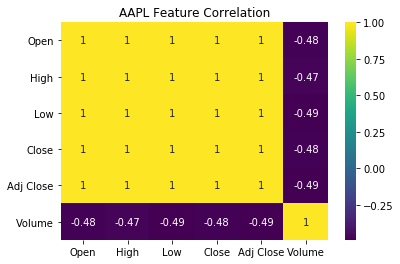

In [8]:
sns.heatmap(df.corr(), cmap=plt.cm.viridis, annot=True)
plt.title(f'{DATASET} Feature Correlation')
plt.savefig(f"plots/{DATASET}_corr.png")

In [9]:
trace = go.Scatter(x=df.index, y=df.Open)
layout = go.Layout(title=f'{DATASET} opening stocks',
                   xaxis={'title': 'Date'}, yaxis={'title': 'Opening Price'})
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)
plot(fig, filename=f'plots/{DATASET}_history.html', auto_open=False)

'file:///home/rbotarleanu/Desktop/repos/data-science-course/h2-stock-predictions/plots/AAPL_history.html'

# LSTM Predictions

In [10]:
data = list(df['Open'].values)

In [11]:
len(data)

1260

In [12]:
window_length = 365 * 3

In [13]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred), axis=-1))

In [14]:
def make_sequences(data, sequence_lengths):
    X = []
    y = []

    for i in range(0, len(data)):
        if i + sequence_lengths >= len(data):
            break
        X.append(data[i:i+sequence_lengths])
        y.append(data[i+sequence_lengths])
    
    return np.array(X), np.array(y)

In [15]:
X, y = make_sequences(data, window_length)

In [16]:
X = X.reshape(-1, window_length, 1)
X.shape

(165, 1095, 1)

In [17]:
# center and scale X
X = (X - np.mean(X)) / np.std(X)

In [18]:
model = Sequential()

model.add(LSTM(32))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.1),
              loss='mean_squared_error', metrics=[rmse])

In [19]:
fit_cb = model.fit(X, y, epochs=300,
                   callbacks=[EarlyStopping(monitor='loss', patience=10)])

Epoch 1/300
165/165 [==============================] - 5s 28ms/step - loss: 35566.5417 - rmse: 187.5262
Epoch 2/300
165/165 [==============================] - 4s 23ms/step - loss: 30122.1945 - rmse: 172.4031
Epoch 3/300
165/165 [==============================] - 3s 21ms/step - loss: 25201.7721 - rmse: 157.5577
Epoch 4/300
165/165 [==============================] - 3s 20ms/step - loss: 20800.4081 - rmse: 142.8565
Epoch 5/300
165/165 [==============================] - 3s 21ms/step - loss: 16947.2788 - rmse: 128.5591
Epoch 6/300
165/165 [==============================] - 4s 23ms/step - loss: 13603.7480 - rmse: 114.8764
Epoch 7/300
165/165 [==============================] - 4s 22ms/step - loss: 10796.2421 - rmse: 101.9672
Epoch 8/300
165/165 [==============================] - 4s 22ms/step - loss: 8459.9063 - rmse: 89.8745
Epoch 9/300
165/165 [==============================] - 4s 22ms/step - loss: 6562.1155 - rmse: 78.5861
Epoch 10/300
165/165 [==============================] - 4s 22ms/step

In [20]:
rmse = go.Scatter(x=fit_cb.epoch, y=fit_cb.history['rmse'], fillcolor='green')
layout = go.Layout(title=f'{DATASET} RMSE plot',
                   xaxis={'title': 'Epoch'}, yaxis={'title': 'RMSE'})
fig = go.Figure(data=[rmse], layout=layout)
iplot(fig)
plot(fig, filename=f'plots/{DATASET}_train_rmse.html', auto_open=False)

'file:///home/rbotarleanu/Desktop/repos/data-science-course/h2-stock-predictions/plots/AAPL_train_rmse.html'